In [2]:
import helper

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
# from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.client import device_lib

In [4]:
print(device_lib.list_local_devices())
tf.test.is_gpu_available(cuda_only=True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4303109146514497203
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2247832372
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11718534949489526470
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
helper.photos.head()

,Target,Score,exact_file,pixels
0,CF437.jpg,2.883333,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,AM1384.jpg,2.466667,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AM1234.jpg,2.150000,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AM1774.jpg,3.750000,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,CF215.jpg,3.033333,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [8]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5000539522714832031
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2247832372
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6053610594175170615
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [9]:
helper.photos.head()

,Target,Score,exact_file,pixels
0,CF437.jpg,2.883333,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,AM1384.jpg,2.466667,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AM1234.jpg,2.150000,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AM1774.jpg,3.750000,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,CF215.jpg,3.033333,C:\Users\nunok\PycharmProjects\pythonProject2\...,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


In [10]:
# train-test split
#train_x, test_x, train_y, test_y = train_test_split(features, photos["Score"].values, test_size=0.4, random_state=17)

X_train, X_test, y_train, y_test = train_test_split(helper.features_preprocessing(), helper.photos["Score"].values, test_size=0.40, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
print(f'train shape: {X_train.shape}, {y_train.shape}\nval shape: {X_val.shape}, {y_val.shape}\ntest shape: {X_test.shape}, {y_test.shape}')

train shape: (3300, 224, 224, 3), (3300,)
val shape: (1100, 224, 224, 3), (1100,)
test shape: (1100, 224, 224, 3), (1100,)


In [14]:
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, \
        Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from sklearn.metrics import mean_absolute_error as mae
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import matplotlib.pyplot as plt


In [15]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6128084504988787380
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2247832372
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4845866672016822021
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [10]:
# Transfer learning
# Apply VGG-FACE
base_model = Sequential()
base_model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
base_model.add(Convolution2D(64, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(128, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(128, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(Convolution2D(4096, (7, 7), activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(4096, (1, 1), activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(2622, (1, 1)))
base_model.add(Flatten())
base_model.add(Activation('softmax'))
 
#pre-trained weights of vgg-face model.
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
base_model.load_weights(r"C:\Users\nunok\PycharmProjects\pythonProject2\vgg_face_weights.h5")

In [11]:
#We will lock the early layers to have some outcomes. We will expect model to learn attractiveness at the final layers. Also, the base model has 2622 outputs but this application will have just one output which is attractiveness score.
num_of_classes = 1 #this is a regression problem
 
#freeze all layers of VGG-Face except last 7 one
for layer in base_model.layers[:-7]:
    layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Flatten()(base_model.layers[-4].output)
base_model_output = Dense(num_of_classes)(base_model_output)
 
attractiveness_model = Model(inputs=base_model.input, outputs=base_model_output)

In [12]:
# Training

attractiveness_model.compile(loss='mean_squared_error'
, optimizer=keras.optimizers.Adam())
 
checkpointer = ModelCheckpoint(filepath='attractiveness.hdf5'
    , monitor = "val_loss", verbose=1
, save_best_only=True, mode = 'auto'
)
 
earlyStop = EarlyStopping(monitor='val_loss', patience=7)

model_fit = attractiveness_model.fit(X_train,y_train, validation_data=(X_val,y_val), callbacks=[checkpointer, earlyStop], epochs = 30)

Epoch 1/30
104/104 [==============================] - ETA: 0s - loss: 0.7410 
Epoch 1: val_loss improved from inf to 0.18062, saving model to attractiveness.hdf5
104/104 [==============================] - 1224s 12s/step - loss: 0.7410 - val_loss: 0.1806
Epoch 2/30
104/104 [==============================] - ETA: 0s - loss: 0.2907 
Epoch 2: val_loss improved from 0.18062 to 0.17331, saving model to attractiveness.hdf5
104/104 [==============================] - 1195s 11s/step - loss: 0.2907 - val_loss: 0.1733
Epoch 3/30
104/104 [==============================] - ETA: 0s - loss: 0.2994 
Epoch 3: val_loss did not improve from 0.17331
104/104 [==============================] - 1176s 11s/step - loss: 0.2994 - val_loss: 0.1793
Epoch 4/30
104/104 [==============================] - ETA: 0s - loss: 0.2430 
Epoch 4: val_loss improved from 0.17331 to 0.13639, saving model to attractiveness.hdf5
104/104 [==============================] - 1190s 11s/step - loss: 0.2430 - val_loss: 0.1364
Epoch 5/30
10

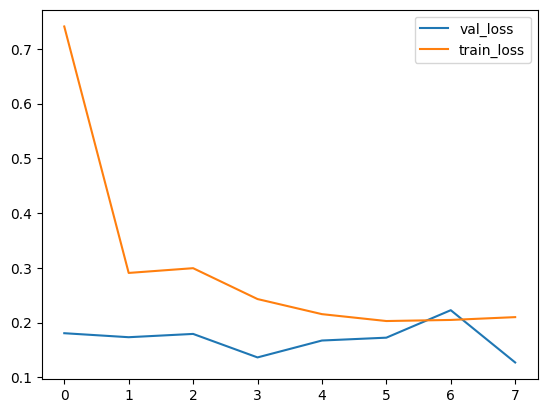

In [13]:
# Loss
loss_plot(model_fit)

In [14]:
predictions = attractiveness_model.predict(X_test)
actuals = y_test

perf = pd.DataFrame(actuals, columns=["actuals"])
perf["predictions"] = predictions

print("pearson correlation: ", perf[['actuals', 'predictions']].corr(method='pearson').values[0, 1])
print("mae: ", mae(actuals, predictions))
print("rmse: ", sqrt(mean_squared_error(actuals, predictions)))


35/35 [==============================] - 89s 2s/step
pearson correlation:  0.844318236343777
mae:  0.28458763614714183
rmse:  0.36903580428802885


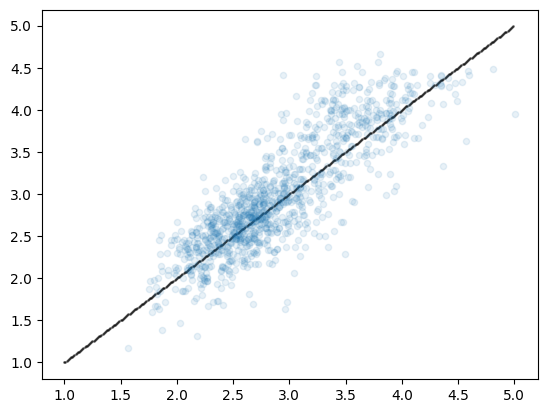

In [17]:
helper.regression_plot(predictions,actuals)

In [23]:
# PREDICT

In [16]:
#import model
model_predict = load_model("attractiveness.hdf5")

In [17]:
helper.file_to_dic()["flat_list"][:5]

['beatriz_masc - Cópia (2).jpg',
 'carmona_feminized.jpg',
 'diogo.jpg',
 'male_diogo_feminized.jpg',
 'male_nuno_masc.jpg']

In [ ]:
data = helper.create_data()
data["predictions"] = model_predict(helper.features_prediction())

In [1]:
data.head()


NameError: name 'data' is not defined

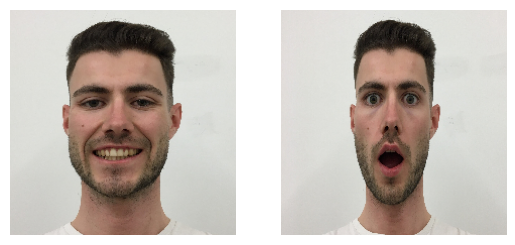

In [257]:

fig = plt.figure()
image1 = plt.subplot(121)
image2 = plt.subplot(122)



img_source2 = tf.keras.utils.load_img(r"C:\Users\nunok\PycharmProjects\pythonProject2\cfd\CFD Version 3.0\fotos\predict\img_1\Image.jpeg",grayscale=False, target_size=(224, 224))

img_source1 = tf.keras.utils.load_img(r"C:\Users\nunok\PycharmProjects\pythonProject2\cfd\CFD Version 3.0\fotos\predict\img_1\Image_2.jpeg", grayscale=False, target_size=(224, 224))

_ = image1.imshow(img_source1)
_ = image2.imshow(img_source2)


image1.axis("off")
image2.axis("off")

plt.show()

In [266]:
attractiveness_model.predict(features)


array([[2.9495406],
       [3.511482 ]], dtype=float32)